In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# API Keys (replace with yours)
EIA_API_KEY = 'FmqkNho2Wz6RGcwjsvKbGaNE9rz4XzwXQ94Yk1Qv'  # From https://www.eia.gov/opendata/register.php
NOAA_TOKEN = 'ktWIcJrJonJYmqRfGlHjuBMAYWeYYoCS'    # From https://www.ncdc.noaa.gov/cdo-web/token

# Base EIA URL
# EIA_BASE = 'https://api.eia.gov/v2
# EIA_BASE_V1 = "https://api.eia.gov/v1/series/"


In [3]:
def fetch_henry_prices(api_key):
    base_url = "https://api.eia.gov/v2/natural-gas/pri/fut/data/"
    
    def fetch_prices(frequency):
        url = f"{base_url}?api_key={api_key}&frequency={frequency}&data[0]=value&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Error fetching {frequency} data: Status {response.status_code}")
            return pd.Series(dtype=float)
        
        json_resp = response.json()
        data_list = json_resp.get("response", {}).get("data", [])
        if not data_list:
            print(f"No {frequency} data found")
            return pd.Series(dtype=float)
        
        df = pd.DataFrame(data_list)
        henry_df = df[df['series-description'].str.contains('Henry Hub', case=False, na=False)].copy()
        if henry_df.empty:
            print(f"No Henry Hub data found in {frequency} data")
            return pd.Series(dtype=float)
        
        if frequency == "monthly":
            henry_df["Date"] = pd.to_datetime(henry_df["period"] + "-01") + pd.offsets.MonthEnd(0)
        else:
            henry_df["Date"] = pd.to_datetime(henry_df["period"])
        
        henry_df["Henry_Price"] = pd.to_numeric(henry_df["value"], errors="coerce")
        henry_df = henry_df.set_index("Date").sort_index().dropna()
        return henry_df["Henry_Price"].tail(200)
    
    monthly_prices = fetch_prices("monthly")
    weekly_prices = fetch_prices("weekly")
    return monthly_prices, weekly_prices

henry_monthly, henry_weekly = fetch_henry_prices(EIA_API_KEY)


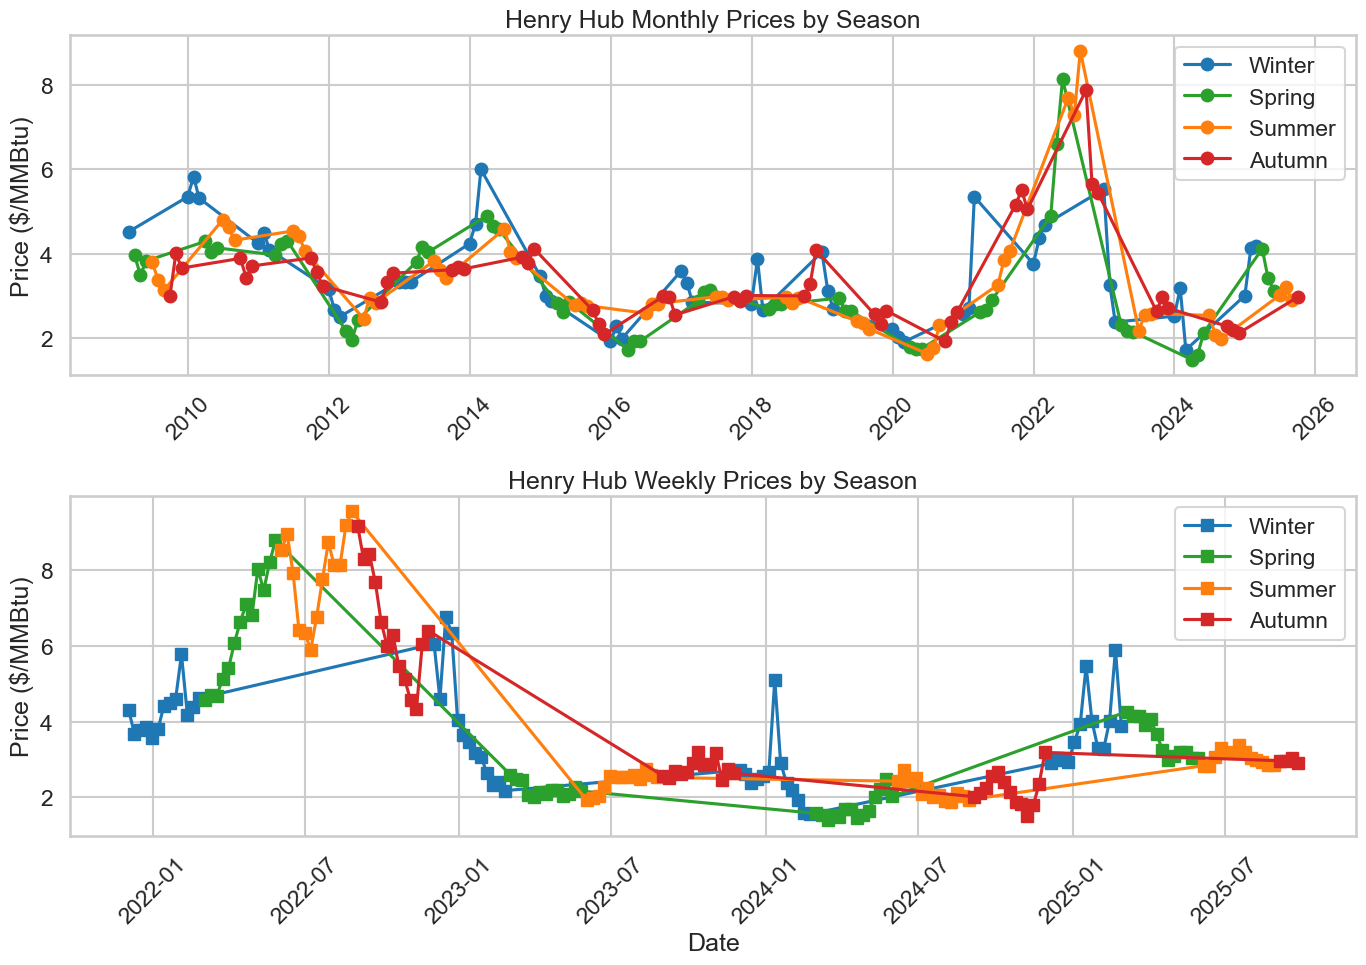

In [4]:
def assign_season(date):
    month = date.month
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Autumn'

def plot_seasonal(monthly, weekly):
    sns.set_style("whitegrid")
    sns.set_context("talk")
    season_colors = {'Winter':'#1f77b4', 'Spring':'#2ca02c', 'Summer':'#ff7f0e', 'Autumn':'#d62728'}
    
    monthly_season = monthly.to_frame()
    monthly_season['Season'] = monthly_season.index.map(assign_season)
    
    weekly_season = weekly.to_frame()
    weekly_season['Season'] = weekly_season.index.map(assign_season)
    
    fig, axes = plt.subplots(2, 1, figsize=(14,10))
    
    for season, color in season_colors.items():
        axes[0].plot(monthly_season[monthly_season['Season']==season].index,
                     monthly_season[monthly_season['Season']==season]['Henry_Price'],
                     marker='o', linestyle='-', color=color, label=season)
        
        axes[1].plot(weekly_season[weekly_season['Season']==season].index,
                     weekly_season[weekly_season['Season']==season]['Henry_Price'],
                     marker='s', linestyle='-', color=color, label=season)
    
    axes[0].set_title("Henry Hub Monthly Prices by Season")
    axes[0].set_ylabel("Price ($/MMBtu)")
    axes[0].legend()
    
    axes[1].set_title("Henry Hub Weekly Prices by Season")
    axes[1].set_ylabel("Price ($/MMBtu)")
    axes[1].set_xlabel("Date")
    axes[1].legend()
    
    for ax in axes:
        plt.sca(ax)
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_seasonal(henry_monthly, henry_weekly)


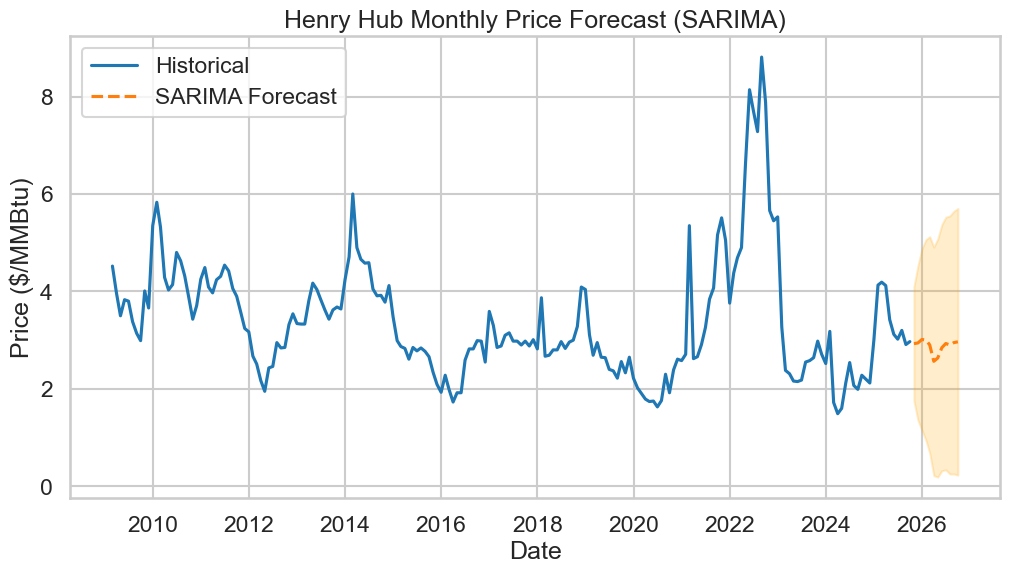

In [5]:
# Monthly SARIMA Forecast (seasonal: 12 months)
sarima_model = SARIMAX(henry_monthly, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit(disp=False)

forecast_steps = 12  # Next 12 months
forecast_index = pd.date_range(start=henry_monthly.index[-1] + pd.offsets.MonthEnd(1),
                               periods=forecast_steps, freq='M')
forecast_values = sarima_fit.get_forecast(steps=forecast_steps).predicted_mean
forecast_ci = sarima_fit.get_forecast(steps=forecast_steps).conf_int()

# Plot
plt.figure(figsize=(12,6))
plt.plot(henry_monthly.index, henry_monthly, label='Historical')
plt.plot(forecast_index, forecast_values, label='SARIMA Forecast', linestyle='--')
plt.fill_between(forecast_index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='orange', alpha=0.2)
plt.title("Henry Hub Monthly Price Forecast (SARIMA)")
plt.xlabel("Date")
plt.ylabel("Price ($/MMBtu)")
plt.legend()
plt.show()


In [7]:
from statsmodels.formula.api import ols
# Trend detection using OLS
monthly_df = henry_monthly.to_frame().reset_index()
monthly_df['t'] = np.arange(len(monthly_df))
ols_model = ols("Henry_Price ~ t", data=monthly_df).fit()
print("OLS Trend Summary:\n", ols_model.summary())

# Seasonality check: average price per season
monthly_df['Season'] = monthly_df['Date'].map(assign_season)
seasonal_avg = monthly_df.groupby('Season')['Henry_Price'].mean().sort_values()
print("\nAverage Henry Hub Price by Season:\n", seasonal_avg)


OLS Trend Summary:
                             OLS Regression Results                            
Dep. Variable:            Henry_Price   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     4.331
Date:                Tue, 07 Oct 2025   Prob (F-statistic):             0.0387
Time:                        14:55:48   Log-Likelihood:                -322.33
No. Observations:                 200   AIC:                             648.7
Df Residuals:                     198   BIC:                             655.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6879      0.172

In [10]:
NOAA_BASE = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"

# Visualization style
sns.set_style("whitegrid")
sns.set_context("talk")


In [18]:
import time

# Base NOAA URL (updated to current NCEI domain)
NOAA_BASE = 'https://www.ncei.noaa.gov/cdo-web/api/v2/data'

def fetch_noaa_monthly_data(station_id="GHCND:USW00012918", start_year=2020, end_year=2025):
    headers = {'token': NOAA_TOKEN}
    all_data = []
    
    # Loop over years
    for year in range(start_year, end_year + 1):
        year_start = f"{year}-01-01"
        if year == end_year:
            year_end = "2025-10-07"  # Current date
        else:
            year_end = f"{year}-12-31"
        
        params = {
            'datasetid': 'GHCND',
            'stationid': station_id,
            'datatypeid': 'TAVG',  # Only TAVG; compute HDD/CDD from it
            'startdate': year_start,
            'enddate': year_end,
            'limit': 1000,
            'units': 'standard'  # Fahrenheit, tenths
        }
        
        max_retries = 3
        for attempt in range(max_retries):
            response = requests.get(NOAA_BASE, headers=headers, params=params)
            if response.status_code == 200:
                break
            elif response.status_code == 503:
                print(f"503 for {year}, attempt {attempt+1}/{max_retries}; retrying in 5s...")
                time.sleep(5)
                continue
            else:
                print(f"Error fetching NOAA data for {year}: {response.status_code}, {response.text[:200]}")
                break
        
        if response.status_code != 200:
            print(f"Failed to fetch {year} after retries.")
            continue
        
        data = response.json().get("results", [])
        if data:
            all_data.extend(data)
            print(f"Fetched {len(data)} records for {year}")
        else:
            print(f"No data for {year}")
        
        time.sleep(1)  # Rate limit courtesy
    
    if not all_data:
        print("No NOAA data found across all years.")
        return pd.DataFrame()
    
    df = pd.DataFrame(all_data)
    if df.empty:
        print("Empty DataFrame after processing.")
        return pd.DataFrame()
    
    # Process: TAVG in tenths of °F
    df['date'] = pd.to_datetime(df['date'])
    df['T_F'] = df['value'] / 10.0  # Convert to actual °F
    df['daily_hdd'] = np.maximum(65 - df['T_F'], 0)  # Base 65°F
    df['daily_cdd'] = np.maximum(df['T_F'] - 65, 0)
    
    # Monthly aggregation: mean temp, sum DD
    monthly_df = df.groupby(df['date'].dt.to_period('M')).agg({
        'T_F': 'mean',
        'daily_hdd': 'sum',
        'daily_cdd': 'sum'
    }).reset_index()
    
    monthly_df['date'] = monthly_df['date'].dt.to_timestamp()
    monthly_df = monthly_df.rename(columns={'T_F': 'Temp_F', 'daily_hdd': 'Heating_DD', 'daily_cdd': 'Cooling_DD'})
    return monthly_df

# Example usage:
noaa_df = fetch_noaa_monthly_data(start_year=2020, end_year=2025)
print("NOAA Monthly Data (Houston):")
print(noaa_df.head())
print(f"Total rows: {len(noaa_df)}")

Fetched 366 records for 2020
Fetched 365 records for 2021
Fetched 365 records for 2022
Fetched 365 records for 2023
Fetched 366 records for 2024
Fetched 239 records for 2025
NOAA Monthly Data (Houston):
        date    Temp_F  Heating_DD  Cooling_DD
0 2020-01-01  5.948387      1830.6         0.0
1 2020-02-01  5.855172      1715.2         0.0
2 2020-03-01  7.138710      1793.7         0.0
3 2020-04-01  7.213333      1733.6         0.0
4 2020-05-01  7.787097      1773.6         0.0
Total rows: 68


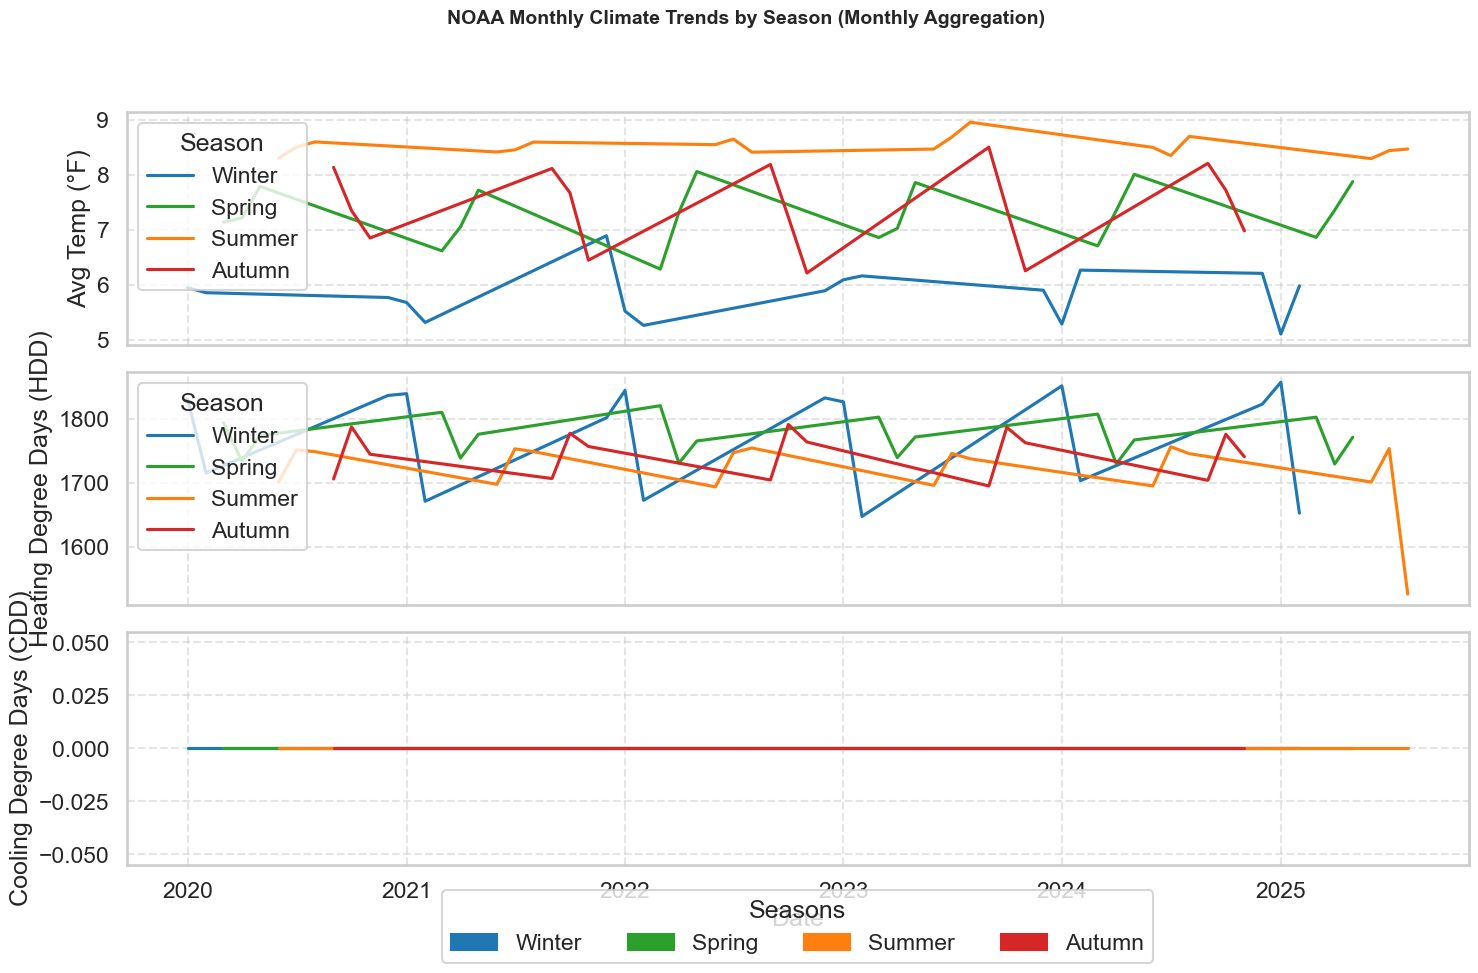

In [30]:
# =====================================================
# A4. NOAA Climate Trend Visualization (Seasonal lines)
# - Aligns to monthly periods for robust merging later
# =====================================================
import matplotlib.patches as mpatches

def plot_noaa_trends_seasonal(noaa_df):
    noaa = noaa_df.copy()
    noaa['date'] = pd.to_datetime(noaa['date'])
    # Convert to monthly period for consistent alignment
    noaa['period'] = noaa['date'].dt.to_period('M')
    monthly = noaa.groupby('period').agg({
        'Temp_F': 'mean',
        'Heating_DD': 'sum',
        'Cooling_DD': 'sum'
    }).reset_index()
    # convert period back to timestamp for plotting (use period start)
    monthly['date'] = monthly['period'].dt.to_timestamp()
    
    # assign season
    def assign_season_month(m):
        if m in [12,1,2]: return 'Winter'
        if m in [3,4,5]: return 'Spring'
        if m in [6,7,8]: return 'Summer'
        return 'Autumn'
    monthly['Season'] = monthly['date'].dt.month.map(assign_season_month)
    
    season_colors = {'Winter':'#1f77b4','Spring':'#2ca02c','Summer':'#ff7f0e','Autumn':'#d62728'}
    metrics = [('Temp_F', 'Avg Temp (°F)', 'tomato'),
               ('Heating_DD', 'Heating Degree Days (HDD)', 'royalblue'),
               ('Cooling_DD', 'Cooling Degree Days (CDD)', 'darkorange')]
    
    fig, axes = plt.subplots(3,1, figsize=(15,10), sharex=True)
    for ax, (col, label, color) in zip(axes, metrics):
        for season, col_color in season_colors.items():
            sub = monthly[monthly['Season'] == season]
            ax.plot(sub['date'], sub[col], label=season, color=col_color)
        ax.set_ylabel(label)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(title='Season', loc='upper left')
    
    axes[-1].set_xlabel('Date')
    plt.suptitle("NOAA Monthly Climate Trends by Season (Monthly Aggregation)", fontsize=14, fontweight='bold')
    # Season legend patch (single global legend)
    patches = [mpatches.Patch(color=c, label=s) for s,c in season_colors.items()]
    plt.legend(handles=patches, title='Seasons', loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.06))
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()
    
# Example usage:
plot_noaa_trends_seasonal(noaa_df)


📈 Correlation with Henry Hub Prices:
   • Avg Temperature (°F): 0.022
   • Heating Degree Days:   -0.023
   • Cooling Degree Days:   nan



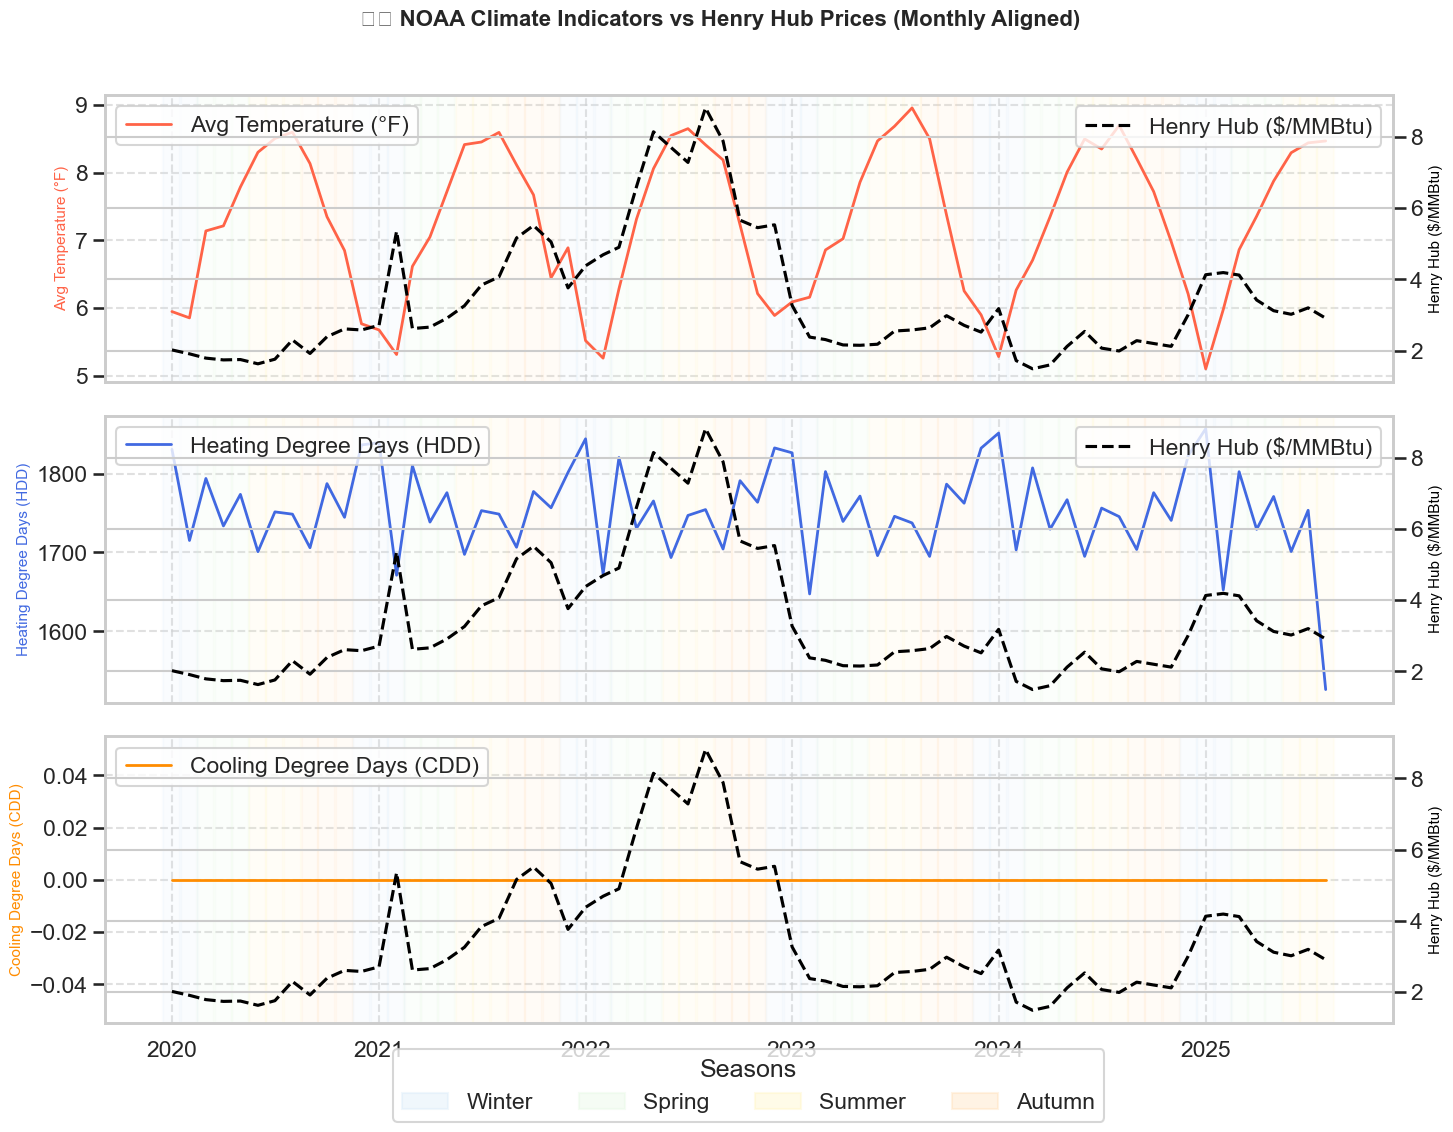

In [35]:
# =====================================================
# 🔗 A5: Henry Hub vs NOAA Climate Data (Monthly Aligned)
# =====================================================

def plot_henry_vs_noaa_period_aligned(henry_monthly, noaa_df, max_lag=3):
    """
    Align Henry Hub monthly prices with NOAA climate indicators.
    Computes correlation, optionally explores lags, and plots overlay.
    """
    import matplotlib.patches as mpatches
    
    # -----------------------------
    # Prepare Henry Hub data
    # -----------------------------
    h = henry_monthly.copy()
    if h.name is None:
        h.name = 'Henry_Price'
    
    h_period = h.reset_index()
    h_period.columns = ['date', 'Henry_Price']
    h_period['period'] = h_period['date'].dt.to_period('M')
    h_period = h_period.groupby('period')['Henry_Price'].mean().reset_index()
    
    # -----------------------------
    # Prepare NOAA data
    # -----------------------------
    n = noaa_df.copy()
    if 'date' not in n.columns:
        n = n.rename(columns={n.columns[0]: 'date'})
    n['period'] = pd.to_datetime(n['date']).dt.to_period('M')
    n_period = n.groupby('period').mean().reset_index()
    
    # -----------------------------
    # Merge datasets
    # -----------------------------
    merged = pd.merge(h_period, n_period, on='period', how='inner').dropna()
    if merged.empty:
        print("⚠️ No overlapping data between Henry Hub and NOAA datasets")
        return
    
    # Convert period back to datetime for plotting
    merged['date'] = merged['period'].dt.to_timestamp()
    
    # -----------------------------
    # Compute correlations
    # -----------------------------
    corr_temp = merged['Henry_Price'].corr(merged['Temp_F'])
    corr_hdd  = merged['Henry_Price'].corr(merged['Heating_DD'])
    corr_cdd  = merged['Henry_Price'].corr(merged['Cooling_DD'])
    
    print(f"📈 Correlation with Henry Hub Prices:")
    print(f"   • Avg Temperature (°F): {corr_temp:.3f}")
    print(f"   • Heating Degree Days:   {corr_hdd:.3f}")
    print(f"   • Cooling Degree Days:   {corr_cdd:.3f}\n")
    
    # -----------------------------
    # Plot overlay
    # -----------------------------
    fig, axes = plt.subplots(3, 1, figsize=(15, 11), sharex=True)
    cols = ['Temp_F', 'Heating_DD', 'Cooling_DD']
    colors = ['tomato', 'royalblue', 'darkorange']
    labels = ['Avg Temperature (°F)', 'Heating Degree Days (HDD)', 'Cooling Degree Days (CDD)']
    
    # Season colors for background shading
    season_colors = {'Winter':'#D0E6F8', 'Spring':'#DFF6DD', 'Summer':'#FFF4B5', 'Autumn':'#FFD8A8'}
    def assign_season(month):
        if month in [12,1,2]: return 'Winter'
        elif month in [3,4,5]: return 'Spring'
        elif month in [6,7,8]: return 'Summer'
        else: return 'Autumn'
    merged['Season'] = merged['date'].dt.month.apply(assign_season)
    
    for ax, col, color, label in zip(axes, cols, colors, labels):
        ax2 = ax.twinx()
        
        # Plot NOAA
        ax.plot(merged['date'], merged[col], color=color, linewidth=2, label=label)
        ax.set_ylabel(label, color=color, fontsize=11)
        
        # Plot Henry
        ax2.plot(merged['date'], merged['Henry_Price'], color='black', linestyle='--', label='Henry Hub ($/MMBtu)')
        ax2.set_ylabel("Henry Hub ($/MMBtu)", color='black', fontsize=11)
        
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # Seasonal shading
        for i, dt in enumerate(merged['date']):
            season = merged['Season'].iloc[i]
            ax.axvspan(dt - pd.Timedelta(days=15), dt + pd.Timedelta(days=15), color=season_colors[season], alpha=0.1)
        
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
    
    plt.suptitle("🌡️ NOAA Climate Indicators vs Henry Hub Prices (Monthly Aligned)", fontsize=16, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Legend for season colors
    season_patches = [mpatches.Patch(color=c, alpha=0.3, label=s) for s,c in season_colors.items()]
    plt.legend(handles=season_patches, title="Seasons", loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.05))
    
    plt.show()
    
    return merged

# Example usage:
merged_df = plot_henry_vs_noaa_period_aligned(henry_monthly, noaa_df)


📊 Lagged Correlation Table:


Metric,Cooling_DD,Heating_DD,Temp_F
Lag_Months,,,
0,NaN,-0.023477,0.021976
1,NaN,0.001624,0.082647
2,NaN,-0.040878,0.095371
3,NaN,-0.099773,0.095812



📈 OLS Regression: Henry Hub ~ Lagged Climate Indicators
                            OLS Regression Results                            
Dep. Variable:            Henry_Price   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.2671
Date:                Tue, 07 Oct 2025   Prob (F-statistic):              0.766
Time:                        16:05:35   Log-Likelihood:                -132.34
No. Observations:                  67   AIC:                             270.7
Df Residuals:                      64   BIC:                             277.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

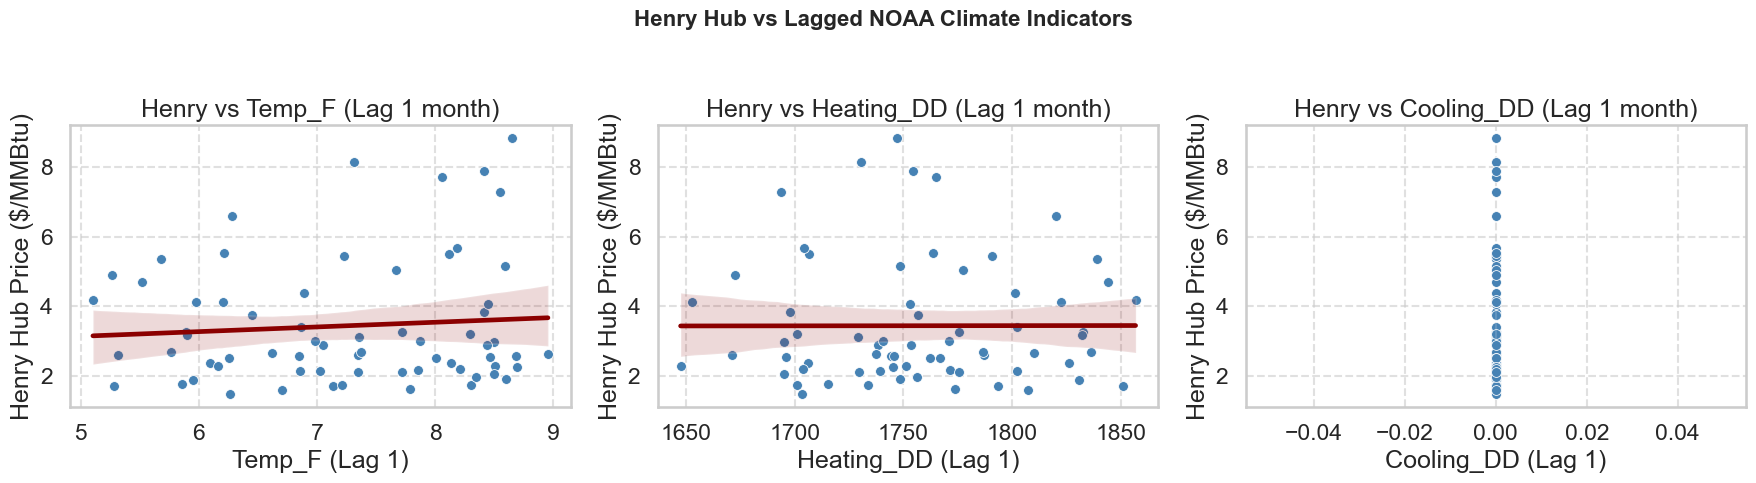

In [37]:
# =====================================================
# 📊 A6: Lagged Correlation & Regression Analysis (Updated)
# =====================================================
def lagged_correlation_analysis(merged_df, max_lag=3):
    """
    Explore lagged correlations between Henry Hub prices and NOAA climate indicators.
    max_lag: maximum months to lag NOAA data (Henry leads or lags)
    """
    # Ensure data is sorted
    df = merged_df.sort_values('date').reset_index(drop=True)
    
    # Prepare lagged correlations
    metrics = ['Temp_F', 'Heating_DD', 'Cooling_DD']
    lag_results_list = []
    
    for metric in metrics:
        for lag in range(0, max_lag + 1):
            # Henry lead vs NOAA lag
            corr = df['Henry_Price'].corr(df[metric].shift(lag))
            lag_results_list.append({'Metric': metric, 'Lag_Months': lag, 'Correlation': corr})
    
    lag_results = pd.DataFrame(lag_results_list)
    
    print("📊 Lagged Correlation Table:")
    display(lag_results.pivot(index='Lag_Months', columns='Metric', values='Correlation'))
    
    # -----------------------------
    # Regression: Henry ~ Temp + HDD + CDD
    # -----------------------------
    from statsmodels.formula.api import ols
    # Optionally, use lag=1 for climate indicators
    df_reg = df.copy()
    df_reg['Temp_F_lag1'] = df_reg['Temp_F'].shift(1)
    df_reg['Heating_DD_lag1'] = df_reg['Heating_DD'].shift(1)
    df_reg['Cooling_DD_lag1'] = df_reg['Cooling_DD'].shift(1)
    
    df_reg = df_reg.dropna()
    
    formula = 'Henry_Price ~ Temp_F_lag1 + Heating_DD_lag1 + Cooling_DD_lag1'
    reg_model = ols(formula, data=df_reg).fit()
    print("\n📈 OLS Regression: Henry Hub ~ Lagged Climate Indicators")
    print(reg_model.summary())
    
    # -----------------------------
    # Plot scatter with regression line
    # -----------------------------
    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    for ax, metric, lag_col in zip(axes, metrics, ['Temp_F_lag1','Heating_DD_lag1','Cooling_DD_lag1']):
        sns.scatterplot(x=lag_col, y='Henry_Price', data=df_reg, ax=ax, color='steelblue', s=50)
        sns.regplot(x=lag_col, y='Henry_Price', data=df_reg, ax=ax, scatter=False, color='darkred')
        ax.set_title(f'Henry vs {metric} (Lag 1 month)')
        ax.set_xlabel(f'{metric} (Lag 1)')
        ax.set_ylabel('Henry Hub Price ($/MMBtu)')
        ax.grid(True, linestyle='--', alpha=0.6)
    
    plt.suptitle("Henry Hub vs Lagged NOAA Climate Indicators", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()
    
    return reg_model, lag_results

# Example usage:
reg_model, lag_results = lagged_correlation_analysis(merged_df, max_lag=3)
